# CMU Movie data

In [65]:
import pandas as pd
import numpy as np
import re
import json
import os

from src.data_completion import *
from src.data_preprocessing import *
from src.data_loading import *
from src.data_fetching import *
from src.data_visualization import *

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download datasets
The following code dowloads the datasets that were too heavy to be included, and places them directly in the `data` folder

In [66]:
# Download TMDb Dataset
download_tmdb()

# Download IMDb Dataset
download_imdb("name.basics.tsv")
download_imdb("title.ratings.tsv")
download_imdb("title.principals.tsv")

# Download CMU dataset
download_cmu()


TMDb dataset already exists. Skipping download.
name.basics.tsv already exists. Skipping download.
title.ratings.tsv already exists. Skipping download.
title.principals.tsv already exists. Skipping download.
All required files of CMU are already present. Skipping download.


## Initial data inspection
We will first try to provide a first generic inspection of the CMU movie dataset we decided to work on.

### Load Data
The dataset is divided in 3 parts, the characters, the movies and the plots of the movies.

In [67]:
character_data, movie_data, plot_data = load_data()

### Characters dataset
Let's first have a look to the character dataset.

In [68]:
print(f'There are {character_data.shape[0]} characters with {character_data.shape[1]} features for each.')

There are 450669 characters with 13 features for each.


In [69]:
character_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


We directly note that the actor ethnicities are not human readable, they look to be freebase ids. It's something we will need to fix during preprocessing.
Let's now see how much missing data we have.

In [70]:
print("Percentage of null rows in the characters dataset for each features:")
print(character_data.isnull().mean().round(3)*100)

Percentage of null rows in the characters dataset for each features:
wikipedia_movie_id         0.0
freebase_movie_id          0.0
movie_release_date         2.2
character_name            57.2
actor_dob                 23.6
actor_gender              10.1
actor_height              65.6
actor_ethnicity           76.5
actor_name                 0.3
actor_age_at_release      35.1
character_actor_map_id     0.0
character_id              57.2
actor_id                   0.2
dtype: float64


We see that we miss a lot of character names/ids, actor heights, ethnicity and age at release. We can also check for duplicate rows.

In [71]:
print(f"Duplicated rows: {character_data.duplicated().sum()}")

Duplicated rows: 0


### Movies dataset
Let's now have a look at the movies dataset.

In [72]:
print(f'There are {movie_data.shape[0]} movies with {movie_data.shape[1]} features for each.')

There are 81741 movies with 9 features for each.


In [73]:
movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


Let's now see if we have a lot of missing data. We will also verify that we don't have duplicated rows.

In [74]:
print("Percentage of null rows in the movies dataset for each features:")
print(movie_data.isnull().mean().round(3)*100)

Percentage of null rows in the movies dataset for each features:
wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     8.4
box_office_revenue    89.7
runtime               25.0
languages              0.0
countries              0.0
genres                 0.0
dtype: float64


In [75]:
print(f"Duplicated rows: {movie_data.duplicated().sum()}")

Duplicated rows: 0


Ouch! We only have box office revenue for 10% of our movies, that's not good news since it's a key feature in our research problematic, we will need to fix this. Apart from this, we can also note that we are missing 25% of the runtime information. We could try to improve this. This also applies to the movie release data. For the languages, countries and genres, we note that they are dictionaries meaning that we first need to preprocess them a bit (for example transforming them to a list) to then be able to see the percentage of missing data. We will do it now:

In [76]:
# Extract the readable values for 'languages', 'countries', and 'genres' columns. Also clean the language column.

movie_data['languages'] = movie_data['languages'].apply(lambda x: extract_values(x, clean_func=clean_language))
movie_data['countries'] = movie_data['countries'].apply(lambda x: extract_values(x)) 
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_values(x))  

We can now have a look to the missing data:

In [77]:
# Calculate the number of None (NaN) values for each column
none_languages = movie_data['languages'].isna().mean()
none_countries = movie_data['countries'].isna().mean()
none_genres = movie_data['genres'].isna().mean()

# Print the counts of None (NaN) values
print(f"Percentage of None values in 'languages': {none_languages:.2%}")
print(f"Percentage of None values in 'countries': {none_countries:.2%}")
print(f"Percentage of None values in 'genres': {none_genres:.2%}")

Percentage of None values in 'languages': 16.96%
Percentage of None values in 'countries': 9.98%
Percentage of None values in 'genres': 4.38%


We miss some data but nothing too huge.

### Plot summary dataset
Let's now have a look at the plot summaries dataset.

In [78]:
print(f'There are {plot_data.shape[0]} plot summaries with {plot_data.shape[1]} features for each.')

There are 42303 plot summaries with 2 features for each.


In [79]:
plot_data.head(2)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Let's see if we have some rows that are invalid (no summary or wikipedia id).

In [80]:
print("Pourcentage of null rows in the plot summaries dataset:")
print(plot_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the plot summaries dataset:
wikipedia_movie_id    0.0
summary               0.0
dtype: float64


Good new, we have nothing missing here.

## Data completion

### Missing data
Before going deeper to the analysis, we want to already fix the fact that we are missing data for most of the box office results and some runtime values.

Let's then first to get more data on box office results to decrease the number of missing data we have for now. To do this, we will merge the current dataset with a dataset that contains information about 1,000,000 movies collected from The Movie Database (TMDb), including revenue and runtime (https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download).

In [81]:
# Load the new dataset (and rename some columns)
movies_dataset = pd.read_csv('data/tmbd_movies.csv')
movies_dataset['box_office_revenue'] = pd.to_numeric(movies_dataset['revenue'], errors='coerce') 
movies_dataset['release_date'] = pd.to_datetime(movies_dataset['release_date'], errors='coerce')

# We remove the nan of movie release date since we merge on it
movie_data['movie_release_date'] = pd.to_datetime(movie_data['movie_release_date'], errors='coerce')
movie_data = movie_data.dropna(subset=['movie_release_date'])

movies_dataset.head(2)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,box_office_revenue
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",825532764
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",701729206


In [82]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "box_office_revenue", merge_strategy='prioritize_first')

In [83]:
# Print the before and after missing percentages
print(f"Box office results missing percentage before merge (on title) with wikidata: {before_missing:.2%}")
print(f"Box office results missing percentage after merge (on title) with wikidata: {after_missing:.2%}")

Box office results missing percentage before merge (on title) with wikidata: 82.75%
Box office results missing percentage after merge (on title) with wikidata: 42.65%


Big improvement, that's good. Let's try to improve the runtime data.

In [84]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "runtime", merge_strategy='prioritize_first')

In [85]:
# Print the before and after missing percentages
print(f"Runtime results missing percentage before merge (on title) with The Movies Dataset: {before_missing:.2%}")
print(f"Runtime results missing percentage after merge (on title) with The Movies Dataset: {after_missing:.2%}")

Runtime results missing percentage before merge (on title) with The Movies Dataset: 17.03%
Runtime results missing percentage after merge (on title) with The Movies Dataset: 9.34%


That's pretty cool too, we also want to merge the IMBD ID column because we need it afterwards (and we don't have it with the CMU dataset).

In [86]:
movie_data_merged, _, _ = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "imdb_id", merge_strategy='add_column')

### Adding the rating and lead actors of movies

Now we want to merge with the IMDb datasets (https://developer.imdb.com/non-commercial-datasets/) in order to obtain ratings and lead actors. We consider an actor to be a lead actor if their ordering is 1 or 2.

In [87]:
# Load IMDb ratings and select relevant columns
imdb_ratings = pd.read_csv('data/title.ratings.tsv', sep='\t')
imdb_ratings = imdb_ratings.rename(columns={'tconst': 'imdb_id'})
imdb_ratings = imdb_ratings[['imdb_id', 'averageRating', 'numVotes']]

In [88]:
# Load IMDb names data for actors
imdb_names = pd.read_csv('data/name.basics.tsv', sep='\t')

In [89]:
# Extract lead actors (representing the first and second roles)
filtered_lead_actors = extract_lead_actors()

In [126]:
# Merge the lead actors into movie data
movie_data_merged = merge_lead_actors_and_ratings(movie_data_merged, imdb_names, imdb_ratings, filtered_lead_actors)
movie_data_merged.head(2)


[autoreload of src.data_preprocessing failed: Traceback (most recent call last):
  File "/Users/m/miniconda3/envs/hw1/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/m/miniconda3/envs/hw1/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/m/miniconda3/envs/hw1/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/m/Documents/ada-2024-project-authenticdataaddicts/src/data_prepr

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,title,...,lead_actor_1_x,lead_actor_2_x,averageRating_y,numVotes_y,lead_actor_1_y,lead_actor_2_y,averageRating,numVotes,lead_actor_1,lead_actor_2
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Ghosts of Mars,...,Natasha Henstridge,Ice Cube,4.9,58906.0,Natasha Henstridge,Ice Cube,4.9,58906.0,Natasha Henstridge,Ice Cube
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",Getting Away with Murder: The JonBenét Ramsey ...,...,Alice Barrett,Rod Britt,6.1,77.0,Alice Barrett,Rod Britt,6.1,77.0,Alice Barrett,Rod Britt


In [91]:
print(f"We have {movie_data_merged.shape[0]} rows in our merged movies dataset.")

We have 19101 rows in our merged movies dataset.


### Adding inflation data and inflation adjusted box office
We now want to merge with inflation data from the US Labor bureau (https://data.bls.gov/pdq/SurveyOutputServlet). We choose the United States inflation as our measure for inflation because, as will be discussed in the Deeper Analysis, the movies listed are overwhelmingly produced in the USA.

In [140]:
movie_inflation_data, filtered_percentage = adjust_inflation(movie_data_merged)
print(f"Percentage of movies remaining after filtering for missing inflation data or impossible release date: {(1-filtered_percentage):.2%}")

movie_inflation_data.head(2)

Percentage of movies remaining after filtering for missing inflation data or impossible release date: 86.00%


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,adjusted_box_office
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.323395e+07
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,0.0,0.000000e+00


## Cleaning and removing outliers

Before analyzing the data any further, let's clean our data and remove outliers.

### Character dataset

First thing we want to do is to make our ethnicites human readable. To do it we used the wikidata API to map the IDs. We created a CSV file to avoid making multiple request each time we run the notebook.

In [92]:
merged_character_data = map_ethnicities(character_data)

Ethnicity data already fetched.


We can now do more basic preprocessing. For more details, please have a look to our function in src/data_preprocessing.py. 

In [93]:
character_data_valid = preprocess_characters(merged_character_data)

Number of ages retrieved through calculation (using movie release data and actor dob): 21038
Removing NaN reduced the dataset by: 90.18%
Removing invalid actor heights reduced that dataset by 0.52%.
Removing invalid actor ages reduced that dataset by 0.06%.
Removing ethnicity labels which are uncommon reduced that dataset by 0.89%.


In [94]:
# Print the final dataset size
print(f"Number of characters after preprocessing: {character_data_valid.shape[0]}.")

Number of characters after preprocessing: 43672.


In [95]:
# Check that no nan values still there
character_data_valid.isnull().mean()

wikipedia_movie_id        0.000000
freebase_movie_id         0.000000
movie_release_date        0.220256
character_name            0.000000
actor_dob                 0.000000
actor_gender              0.000000
actor_height              0.000000
actor_name                0.000000
actor_age_at_release      0.000000
character_actor_map_id    0.000000
character_id              0.000000
actor_id                  0.000000
actor_ethnicity_label     0.000000
dtype: float64

This is good. We don't care about the movie_release_date here.

### Movies dataset

We will also remove the outliers and preprocess the movie dataset.

In [96]:
movie_data_valid = preprocess_movies(movie_data_merged)

Removing NaN reduced the dataset by: 23.69%
Removing movies released before 1940 reduced the dataset by: 15.33%
Removing movies lasting less than 1h or more than 3 hours 20mins reduced the dataset by: 6.07%
Removing movies that have less than 500 votes: 29.41%
Removing movies that have no box office revenue: 52.68%


In [97]:
print(f"Number of movies after preprocessing: {movie_data_valid.shape[0]}.")

Number of movies after preprocessing: 3735.


In [98]:
# Check that no nan values still there
movie_data_valid.isnull().mean()

wikipedia_movie_id    0.0
freebase_movie_id     0.0
movie_name            0.0
movie_release_date    0.0
box_office_revenue    0.0
runtime               0.0
languages             0.0
countries             0.0
genres                0.0
imdb_id               0.0
averageRating         0.0
numVotes              0.0
lead_actor_1          0.0
lead_actor_2          0.0
dtype: float64

That looks perfect!

## Movies subset creation with complete lead actors data 

Now that we have the two main actors of each movie, let's see if we have corresponding characteristics in the preprocessed character dataset. First we will extract the characters data of all our lead actors in all our films.

In [99]:
lead_actor_data = extract_movies_with_lead_actors_data(movie_data_valid, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


No missing value makes sense since we preprocessed our character data. Let's try now to see how much data we have on our lead actors.

In [100]:
print(f"We have data for {lead_actor_data.shape[0]/(movie_data_valid["lead_actor_1"].notna().sum() + movie_data_valid["lead_actor_2"].notna().sum())*100}% ({lead_actor_data.shape[0]} actors) of our lead actors")

We have data for 43.038821954484604% (3215 actors) of our lead actors


Ok good, let's now create a subset dataframe that will contains only the movies for which we have complete data on the lead actors.

In [101]:
subset_movies_with_lead_actors_data = movie_data_valid[movie_data_valid['freebase_movie_id'].isin(lead_actor_data['freebase_movie_id'])]

In [102]:
print(f"We have {subset_movies_with_lead_actors_data.shape[0]} movies for which we have full data on our lead actors")

We have 2295 movies for which we have full data on our lead actors


Now that we have this movies subset, we can extract the corresponding lead actors and characters subsets for these movies.

In [103]:
# Filter the character_data_valid dataset to keep only rows with freebase_movie_id present in movie_data_extracted
subset_characters_with_lead_actor_data = character_data_valid[character_data_valid['freebase_movie_id'].isin(subset_movies_with_lead_actors_data['freebase_movie_id'])]

# Extract the relevant columns for characters and associated movies
subset_characters_with_lead_actor_data = subset_characters_with_lead_actor_data[['actor_name', 'actor_dob', 'actor_gender', 'actor_ethnicity_label', 'actor_height', 'actor_age_at_release', 'freebase_movie_id', 'character_name']]

# Display the first few rows of the filtered and extracted data
subset_characters_with_lead_actor_data.head(2)


,actor_name,actor_dob,actor_gender,actor_ethnicity_label,actor_height,actor_age_at_release,freebase_movie_id,character_name
2,Ice Cube,1969-06-15 00:00:00,M,African Americans,1.727,32.0,/m/03vyhn,Desolation Williams
5,Pam Grier,1949-05-26 00:00:00,F,African Americans,1.727,52.0,/m/03vyhn,Commander Helena Braddock


In [104]:
print(f"We have {subset_characters_with_lead_actor_data.shape[0]} characters for the movies subset.")

We have 8255 characters for the movies subset.


In [105]:
subset_lead_actors = extract_movies_with_lead_actors_data(subset_movies_with_lead_actors_data, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


In [106]:
print(f"We have {subset_lead_actors.shape[0]} lead actors for the movies subset.")

We have 3215 lead actors for the movies subset.


## Saving our newly created dataframes

We will save our five dataframes:

- full_movie_data_preprocessed that contains all the movies preprocessed 
- full_characters_data_preprocessed that contains all the characters preprocessed
- subset_movies_with_lead_actors_data that contains movies where we have data on all the lead actors
- lead_actors_data_on_subset_movie that contains information on the lead actors of the previous subset
- character_data_valid_filtered that contains information on all the characters of the previous subset

In [107]:
preprocessed_path = 'data/preprocessed'

# Ensure the directory exists
os.makedirs(preprocessed_path, exist_ok=True)

preprocessed_names = {
    'full_movie_data_preprocessed.csv': movie_data_valid,
    'full_characters_data_preprocessed.csv': character_data_valid,
    'subset_movie_with_full_data_on_lead_actors.csv': subset_movies_with_lead_actors_data,
    'lead_actors_data_on_subset_movie.csv': subset_lead_actors,
    'characters_data_on_subset_movie.csv': subset_characters_with_lead_actor_data
}

for name, df in preprocessed_names.items():
    df.to_csv(os.path.join(preprocessed_path, name), index=False)

## Loading our preprocessed dataframes

We can skip all the preprocessing process and load our dataframes directly here:

In [108]:
# Load the preprocessed datasets
full_movie_data_preprocessed = pd.read_csv('data/preprocessed/full_movie_data_preprocessed.csv')
full_characters_data_preprocessed = pd.read_csv('data/preprocessed/full_characters_data_preprocessed.csv')
subset_movie_with_full_data_on_lead_actors = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')
lead_actors_data_on_subset_movie = pd.read_csv('data/preprocessed/lead_actors_data_on_subset_movie.csv')
characters_data_on_subset_movie = pd.read_csv('data/preprocessed/characters_data_on_subset_movie.csv')

# We must convert dates to datetime
lead_actors_data_on_subset_movie['actor_dob'] = pd.to_datetime(lead_actors_data_on_subset_movie['actor_dob'])
characters_data_on_subset_movie['actor_dob'] = pd.to_datetime(characters_data_on_subset_movie['actor_dob'])
full_movie_data_preprocessed['movie_release_date'] = pd.to_datetime(full_movie_data_preprocessed['movie_release_date'])


## Deeper analysis
Now that our data is more complete, we can do a more in deep analysis.

### Lead actors dataset 

Let's first analyze our dataframe with the lead actors just created. We will start with a summary of the statistics of the numerical features.

In [109]:
lead_actors_data_on_subset_movie.describe()

,wikipedia_movie_id,actor_dob,actor_height,actor_age_at_release
count,3.215000e+03,3215,3215.000000,3215.000000
mean,6.188320e+06,1957-05-28 23:44:46.283048256,1.760905,36.695801
min,3.746000e+03,1893-08-17 00:00:00,1.520000,8.000000
25%,8.385995e+05,1946-02-14 00:00:00,1.700000,28.000000
50%,2.514817e+06,1961-05-06 00:00:00,1.770000,35.000000
75%,7.815867e+06,1970-06-11 00:00:00,1.830000,44.000000
max,3.647825e+07,1998-07-08 00:00:00,2.160000,86.000000
std,8.140101e+06,NaN,0.092571,11.980700


Let's print their distributions:

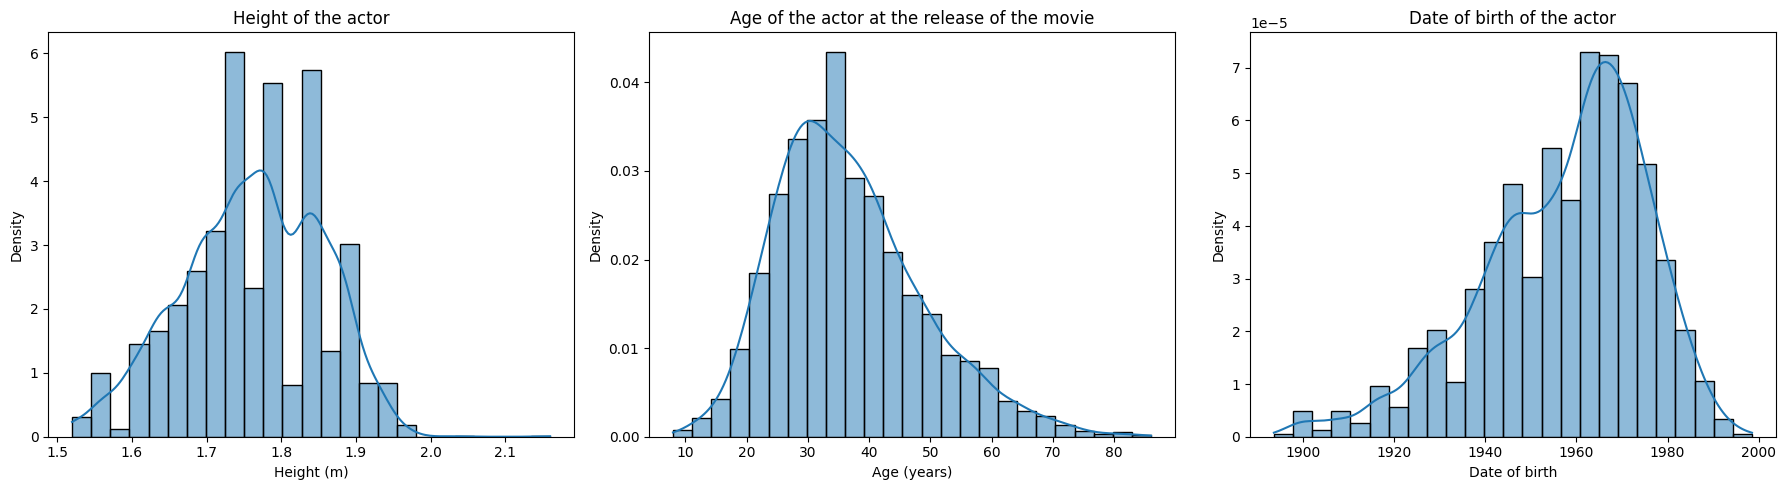

In [110]:
histogram_actors(lead_actors_data_on_subset_movie)

Let's now explore the categorical data.

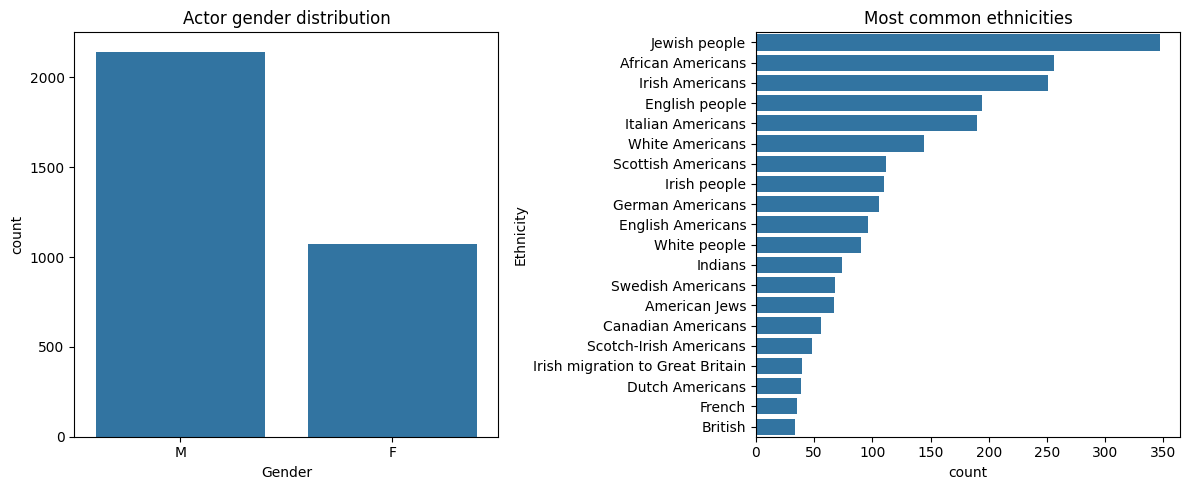

In [111]:
count_actors(lead_actors_data_on_subset_movie)

We can visualize here the correlation matrix between the numerical attributes of the actors.

/var/folders/k8/vtt0k5m17z11cnzn65pw4_b80000gn/T/ipykernel_23477/3839304927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_actors_for_corr.drop('actor_gender', axis=1, inplace=True)


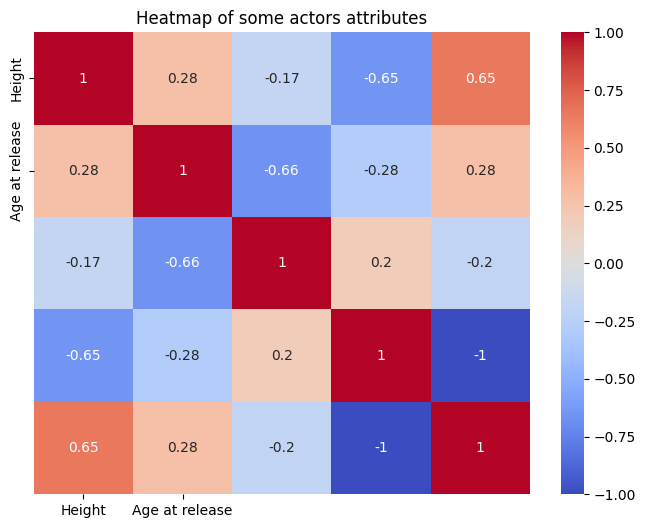

In [112]:
fig, ax = plt.subplots(figsize = (8,6))

lead_actors_for_corr = lead_actors_data_on_subset_movie[['actor_height', 'actor_age_at_release', 'actor_dob', 'actor_gender']]
# Convert gender to boolean by getting dummies
lead_actors_gender_dummies = pd.get_dummies(lead_actors_for_corr['actor_gender'])
lead_actors_for_corr.drop('actor_gender', axis=1, inplace=True)
lead_actors_for_corr = lead_actors_for_corr.join(lead_actors_gender_dummies)
# lead_actors_for_corr['F'] = lead_actors_gender_dummies['F']
# lead_actors_for_corr['M'] = lead_actors_gender_dummies['M']
corr_matrix = lead_actors_for_corr.corr()
label_names = ['Height', 'Age at release']
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names)
ax.set_title('Heatmap of some actors attributes');


### Movies dataset 

Let's now analyse our movies dataset. We will start with a summary of the statistics of the numerical features.

In [113]:
movie_data_completed = full_movie_data_preprocessed.copy()
movie_data_completed.describe()

,wikipedia_movie_id,movie_release_date,box_office_revenue,runtime,averageRating,numVotes
count,3.735000e+03,3735,3.735000e+03,3735.000000,3735.000000,3.735000e+03
mean,7.449150e+06,1991-12-19 16:27:45.542168704,3.902655e+07,107.175556,6.298956,5.745802e+04
min,3.746000e+03,1940-05-17 00:00:00,1.000000e+00,61.000000,1.700000,5.050000e+02
25%,1.121571e+06,1984-12-14 00:00:00,3.000000e+06,95.000000,5.700000,4.791000e+03
50%,3.153784e+06,1995-05-19 00:00:00,1.262604e+07,104.000000,6.400000,1.618700e+04
75%,1.053938e+07,2004-10-11 12:00:00,3.781615e+07,116.000000,6.900000,5.402700e+04
max,3.681425e+07,2013-07-11 00:00:00,9.634204e+08,198.000000,9.000000,2.317973e+06
std,9.066844e+06,NaN,7.820986e+07,18.221764,0.956449,1.268159e+05


Let's print their distributions (except for the wikipedia id):

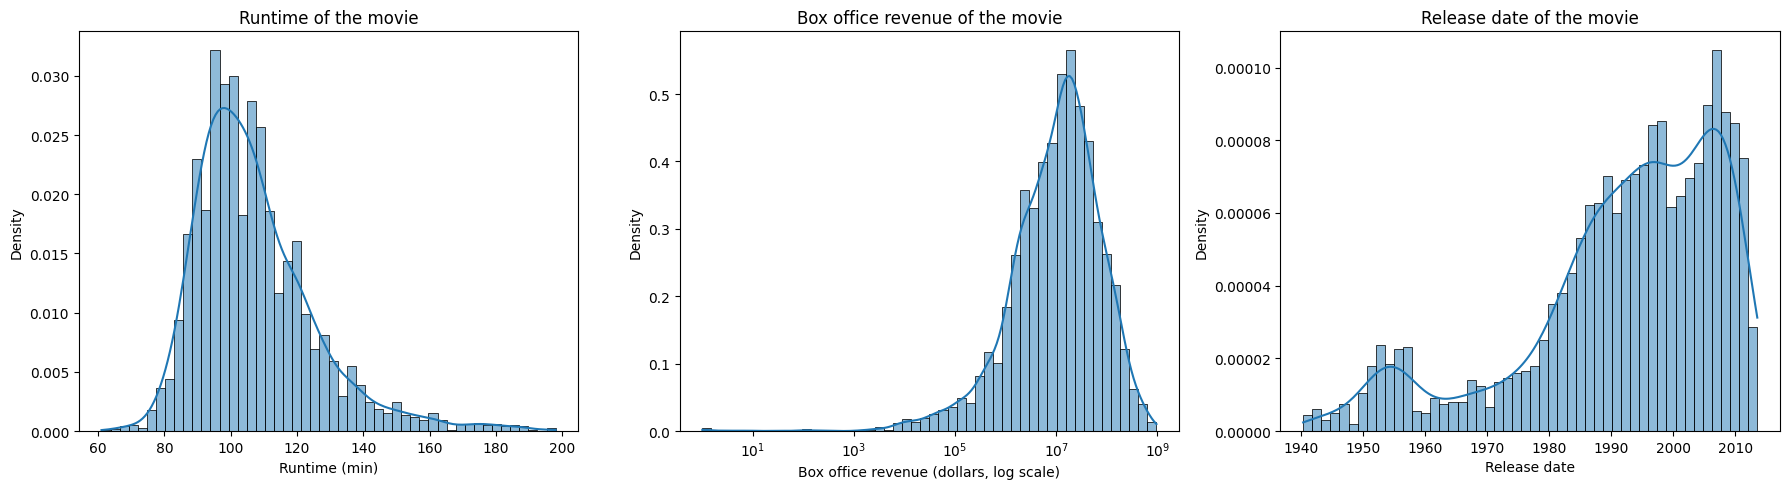

In [114]:
histogram_movies(movie_data_completed)

Let's now look at the ratings and number of votes per movie.

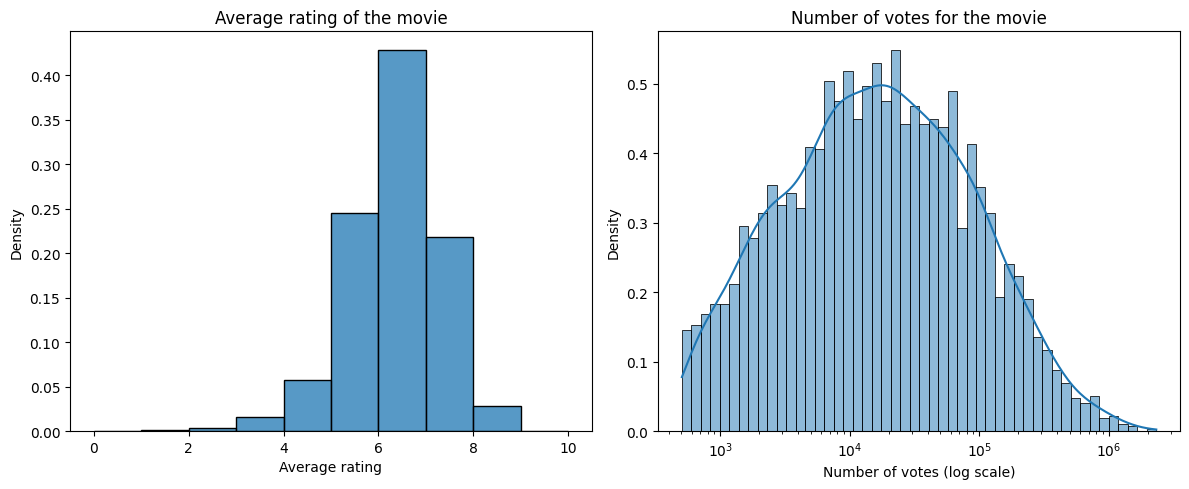

In [115]:
histogram_movie_ratings(movie_data_completed)

We can now have a look at the categorical features:

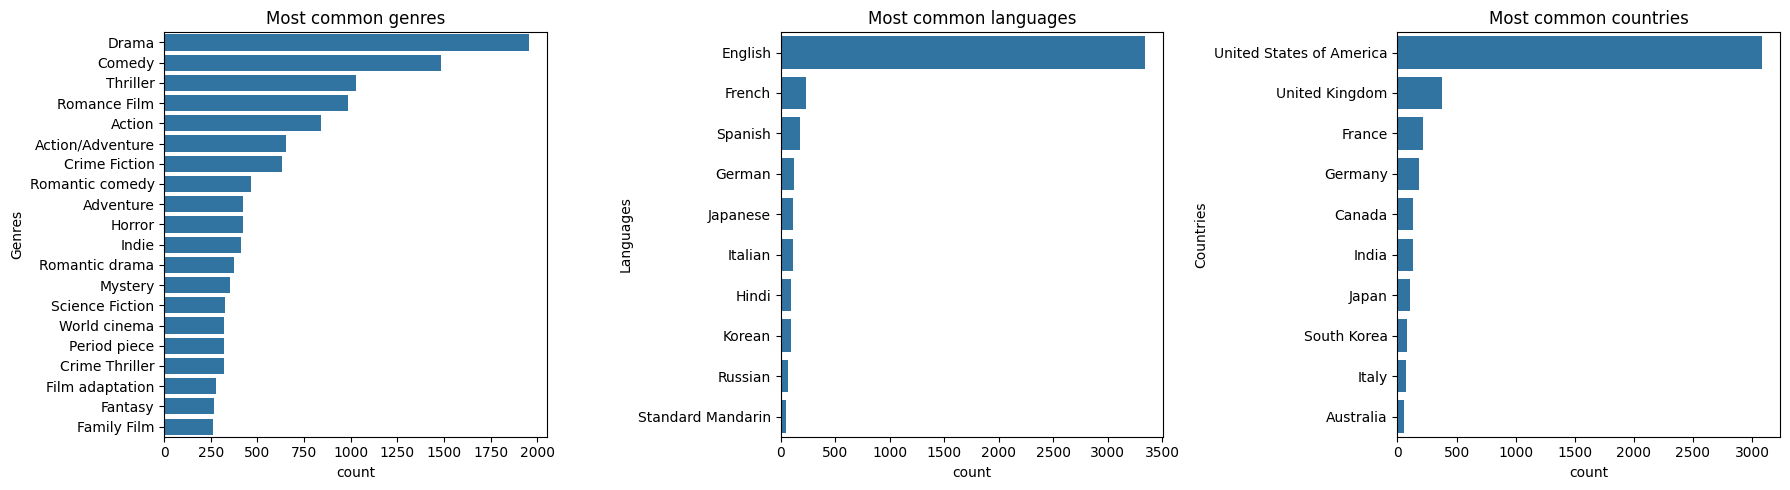

In [116]:
count_movies(movie_data_completed)

As we can expect, the English language and United States of America clearly dominate the movie industry.

### Characters dataset

We now analyze the dataframe with the characters (including non-lead actors). We again start with a summary of the statistics of the numerical features.

In [117]:
characters_data_on_subset_movie.describe()

,actor_dob,actor_height,actor_age_at_release
count,8255,8255.000000,8255.000000
mean,1959-07-13 08:11:34.270139264,1.757610,37.249667
min,1882-10-20 00:00:00,1.510000,5.000000
25%,1948-03-28 00:00:00,1.690000,28.000000
50%,1962-07-03 00:00:00,1.760000,35.000000
75%,1971-06-14 00:00:00,1.830000,45.000000
max,2000-10-31 00:00:00,2.200000,94.000000
std,NaN,0.097182,13.211456


Let's do some plots to visualize better. As it is very similar as the plots from the lead actors dataset, we will compare our plots with the ones from this dataset.

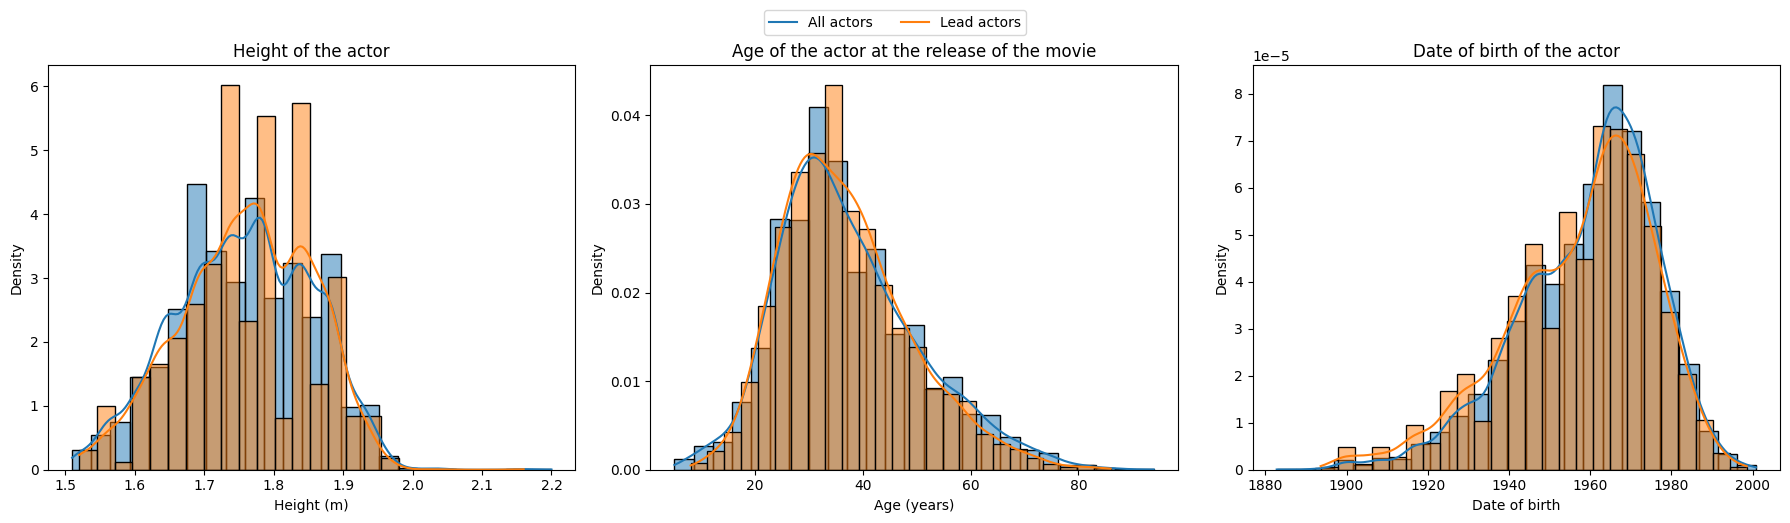

In [118]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histogram_actors(characters_data_on_subset_movie, axes=axes)
histogram_actors(lead_actors_data_on_subset_movie, axes=axes)

fig.tight_layout()
fig.legend(["All actors", "Lead actors"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


Finally we compare the gender distribution between all actors and only lead actors.

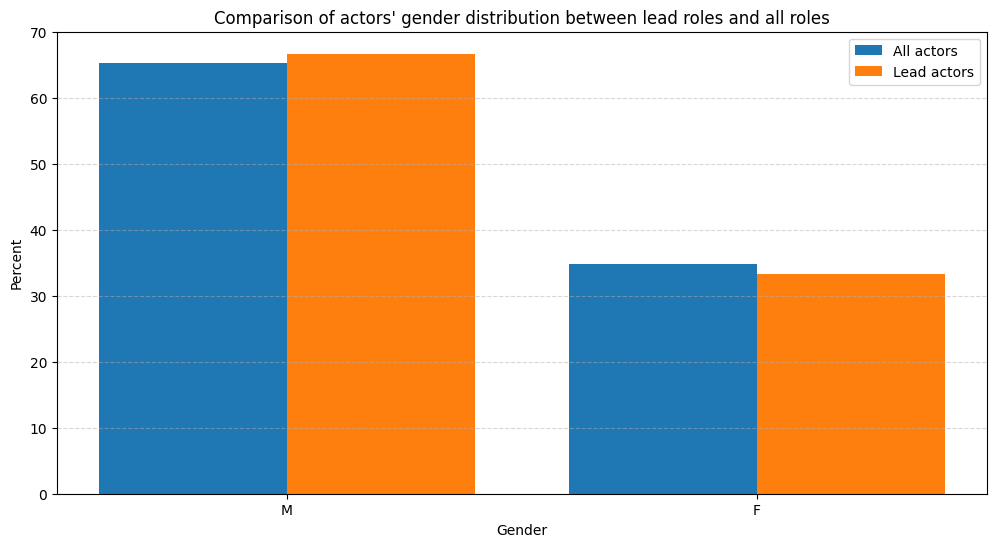

In [119]:
fig, ax = plt.subplots(figsize = (12, 6))
width = 0.4

gender_dist_all = characters_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
gender_dist_lead = lead_actors_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
labels = list(gender_dist_all.keys())

bar_all = ax.bar(labels, gender_dist_all, -width, label="All actors", align='edge')
bar_lead = ax.bar(labels, gender_dist_lead, width, label="Lead actors", align='edge')

ax.set_title("Comparison of actors' gender distribution between lead roles and all roles")
ax.set_xlabel("Gender")
ax.set_ylabel("Percent")
plt.grid(axis='y', linestyle='--', alpha=0.5)

ax.legend()
plt.show()

### Low vs. high rating/revenue analysis

Now let's see at the difference between low and high rated movies as well as between movies with low and high box office revenues!

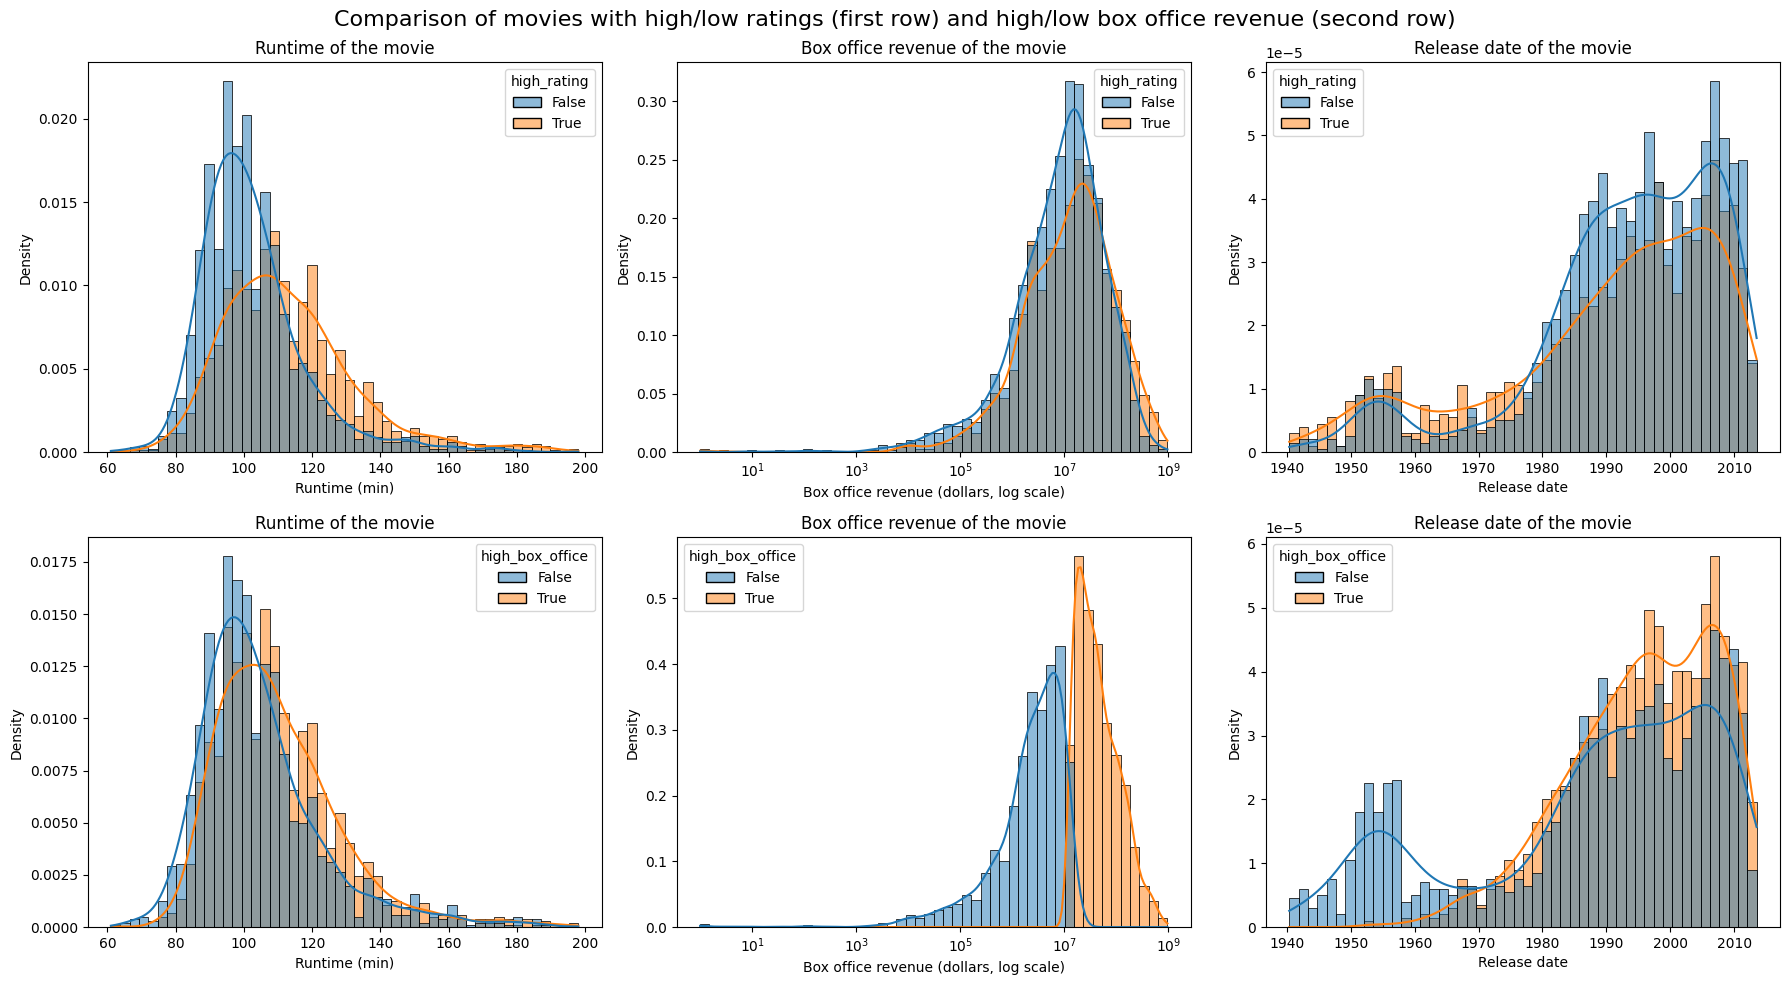

In [120]:
# Split the movies by the median rating and median box office revenue
median_rating = full_movie_data_preprocessed['averageRating'].median()
median_box_office = full_movie_data_preprocessed['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
full_movie_data_preprocessed['high_rating'] = full_movie_data_preprocessed['averageRating'] > median_rating
full_movie_data_preprocessed['high_box_office'] = full_movie_data_preprocessed['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()


First, we see that the box office was correctly split by low/high revenue (see second plot of the second row).

Futhermore, we can observe a slight difference in the runtime distribution between high and low rated/revenue movies.

Now let's look at the average ratings and number of votes.

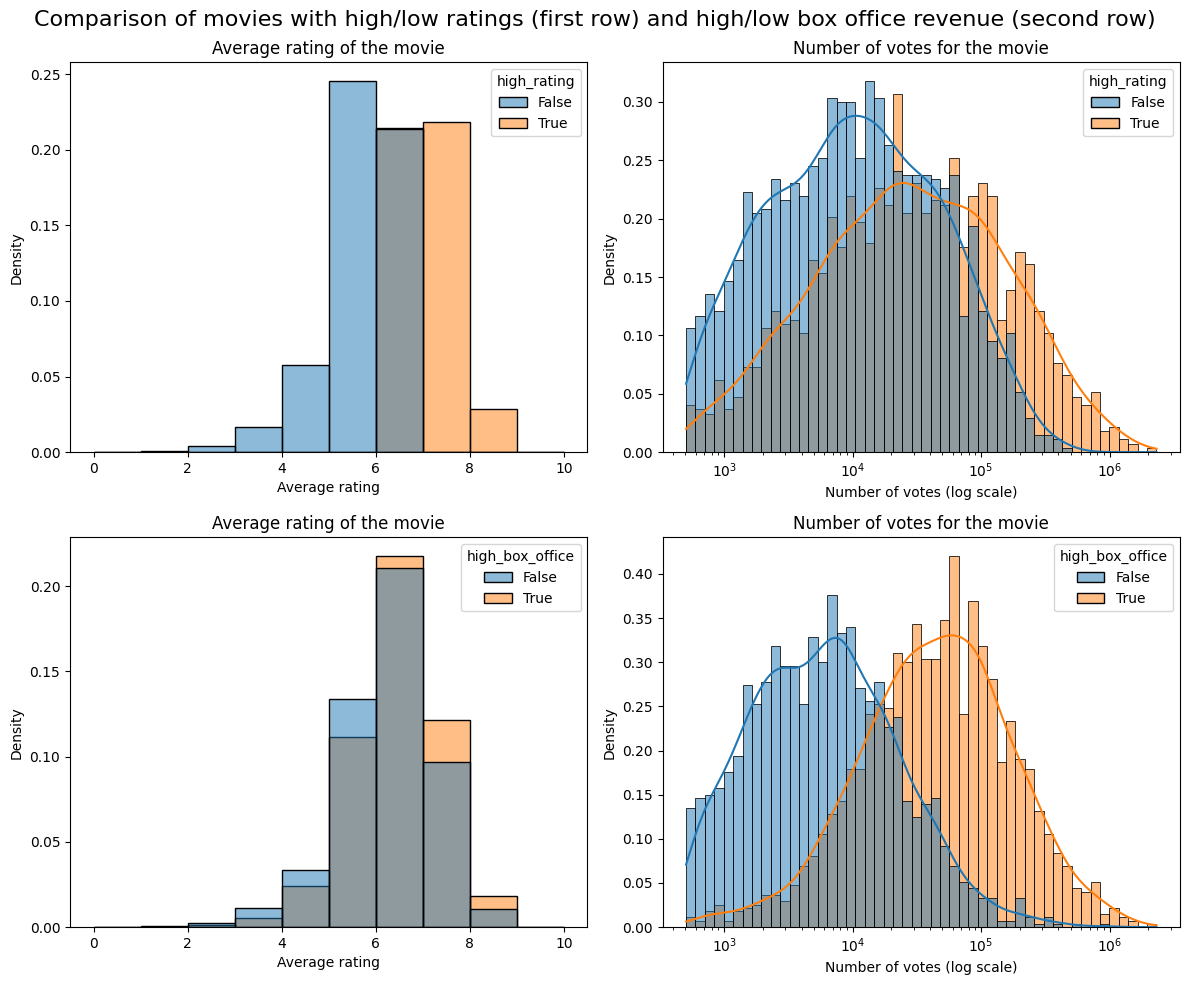

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

histogram_movie_ratings(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movie_ratings(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Again, we see that the data was correctly split into low and high rating (see first plot of the first row).

Further, we can observe that high rated/revenue movies have more votes.

Now, let's look at the categorical features.

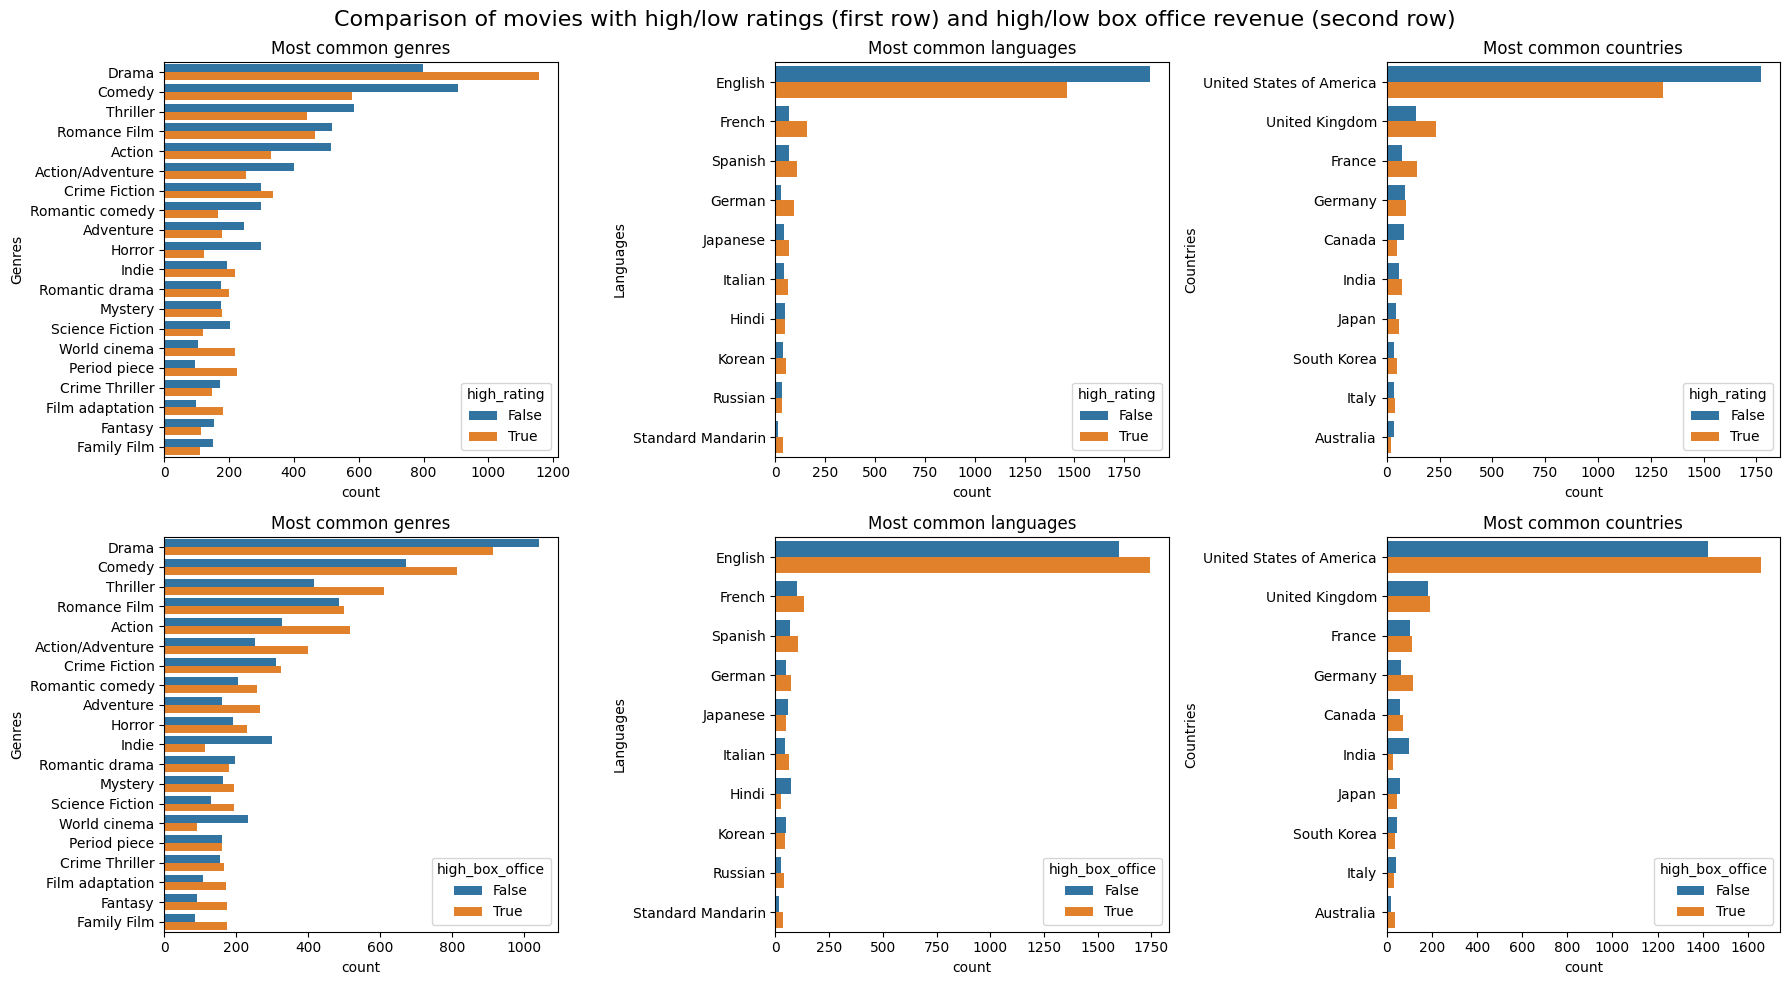

In [122]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

count_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
count_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more higher rated dramas than lower rated one, but there are less high box office revenue dramas as high revenue one.

Futhermore, we see there are more lower rated comedies but they usually have higher box office revenues.

Now let's have a look at the difference in lead actors' attributes between high and low rating movies.

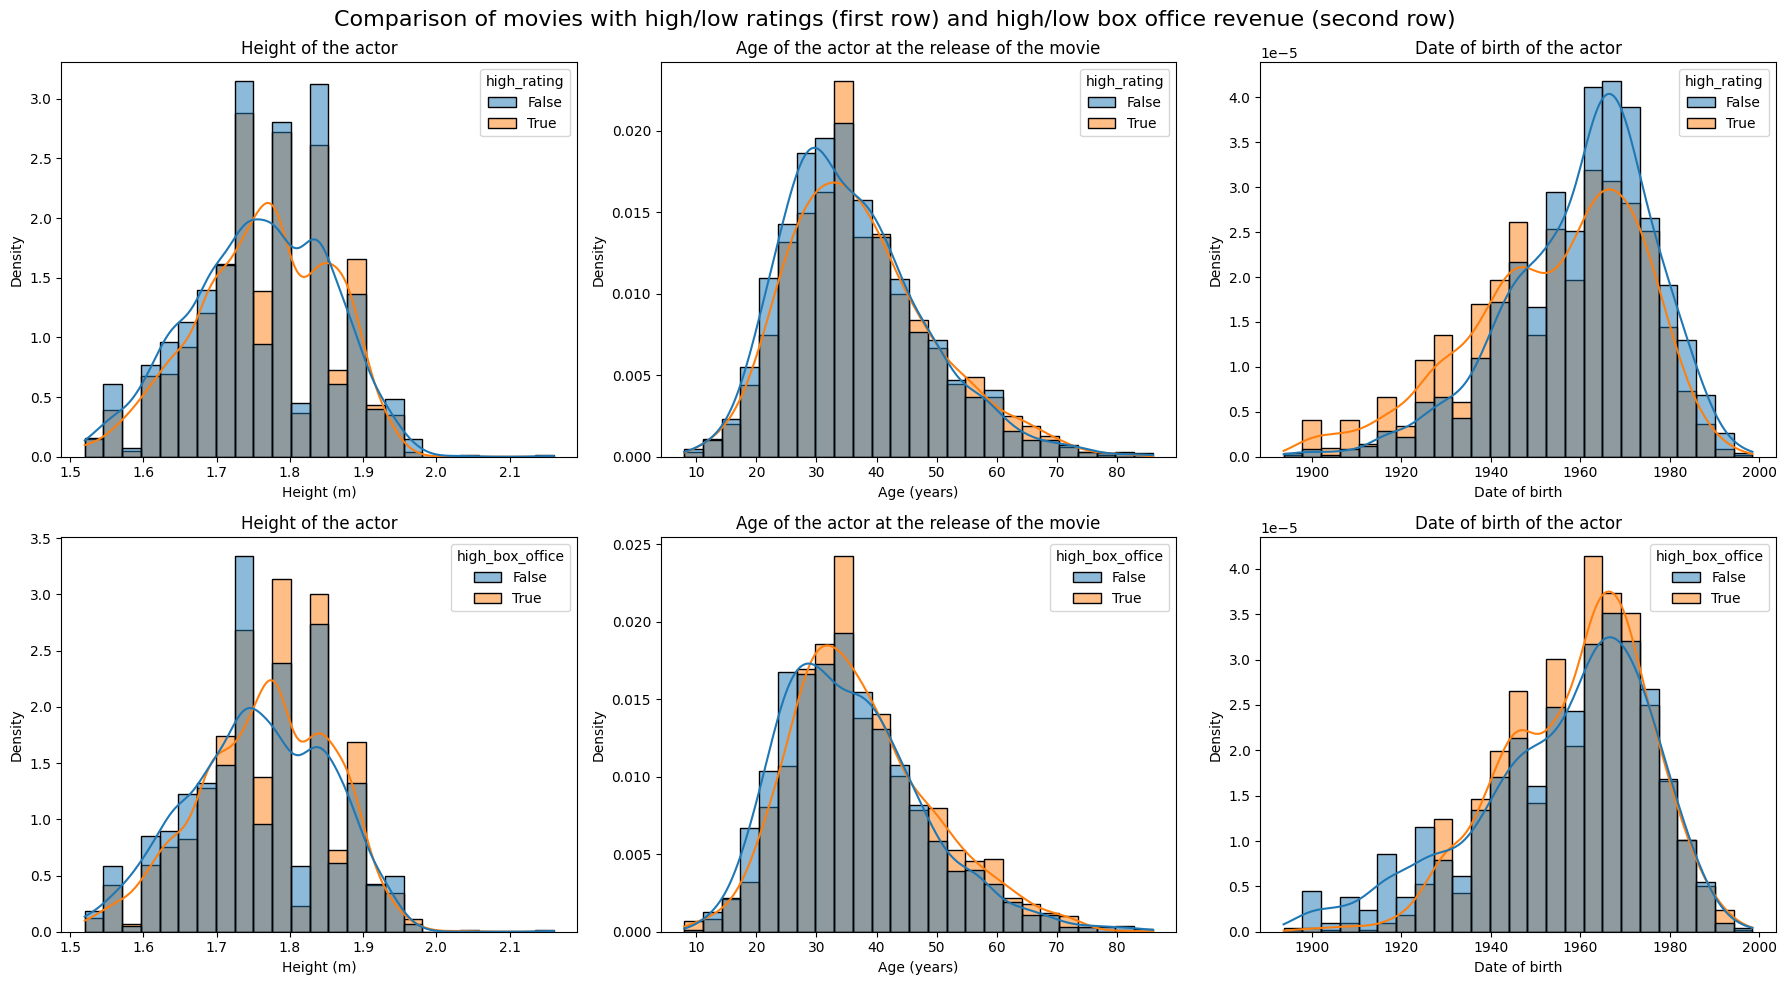

In [123]:
# Merge the movie data with the lead actors data
merged = pd.merge(full_movie_data_preprocessed, lead_actors_data_on_subset_movie, left_on='freebase_movie_id', right_on='freebase_movie_id')

# Split the movies by the median rating and median box office revenue
median_rating = merged['averageRating'].median()
median_box_office = merged['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
merged['high_rating'] = merged['averageRating'] > median_rating
merged['high_box_office'] = merged['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_actors(merged, hue='high_rating', axes=axes[0])
histogram_actors(merged, hue='high_box_office', axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Not much of a difference here, let's look at the categorical attributes.

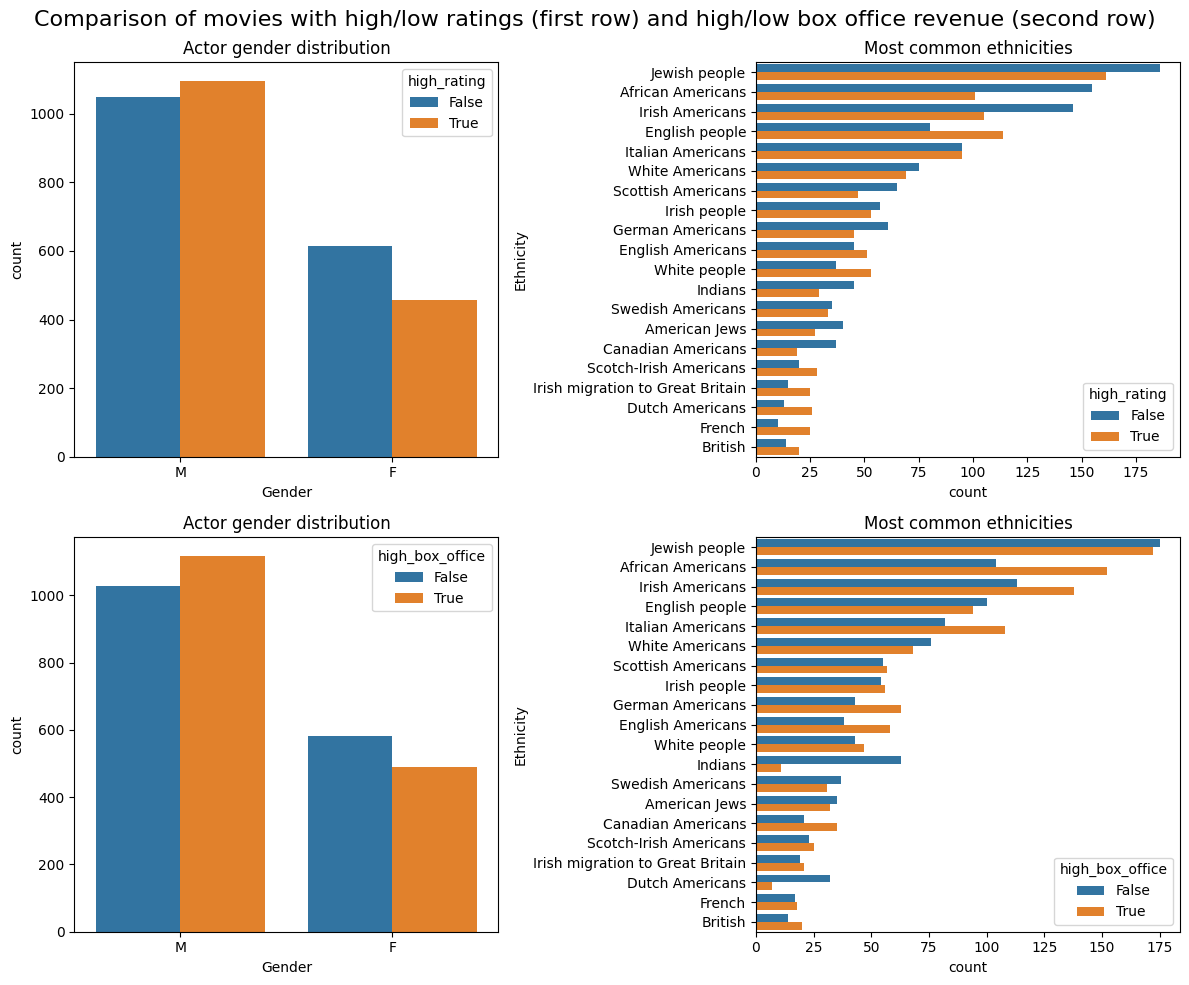

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

count_actors(merged, "high_rating", axes[0])
count_actors(merged, "high_box_office", axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more men in higher rated/revenue movies as in lower rated/revenue movies.
Whereas, it's the opposite for women.

Futhermore, we can see that there are more African Americans in lower rated movies as in high rated movies.
Whereas, it't the opposite for English People.

Interestingly, we see that there are more Affrican Americans in movies with high revenue as in lower box office revenue movies.